In [1]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [3]:
# Numpy のアップグレード
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


ランタイムを再起動してください

In [1]:
# 環境変数を設定
!echo 'export LD_LIBRARY_PATH=/usr/lib' >> ~/.bashrc
!source ~/.bashrc

In [2]:
import pandas_datareader.data as pdr

def get_stock_data(code):
  df = pdr.DataReader("{}.JP".format(code), "stooq").sort_index()
  return df

<ipython-input-3-8a29150a2007>:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = axes[0].get_legend().legendHandles


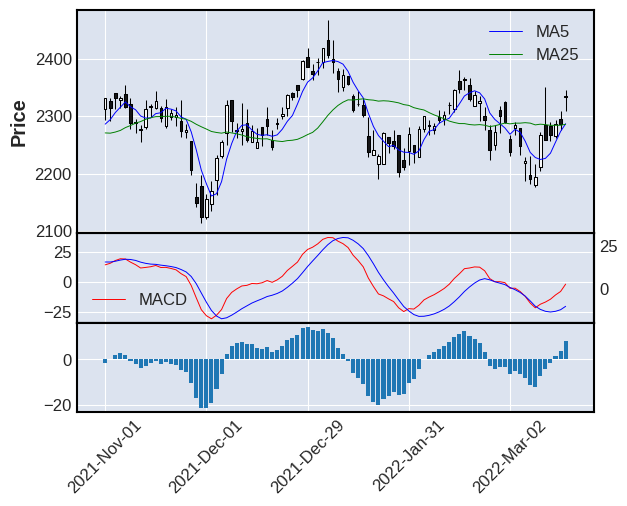

In [3]:
import mplfinance as mpf
import datetime as dt
import numpy as np
import talib as ta

df = get_stock_data(1928)  # 積水ハウス
close = df["Close"]

df['ma5'] = ta.SMA(close ,timeperiod=5)
df['ma25'] = ta.SMA(close ,timeperiod=25)

# MACD、シグナル、ヒストグラムを算出
macd, macdsignal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['macd'] = macd
df['macd_signal'] = macdsignal
df['hist'] = hist

# 2021.11.1から2022.3.17までのチャートを作成
rdf = df[dt.datetime(2021,11,1):dt.datetime(2022,3,17)]

apd  = {
          # 5日移動平均線
          "MA5": mpf.make_addplot(rdf['ma5'], color='blue', 
                                panel=0, width=0.7),
          # 25日移動平均線
          "MA25": mpf.make_addplot(rdf['ma25'], color='green', 
                                panel=0, width=0.7),
          # MACD
          "MACD": mpf.make_addplot(rdf['macd'], panel=1, 
                                width=0.7, color='red'),
          # シグナル
          "macd_signal": mpf.make_addplot(rdf['macd_signal'], panel=1, 
                                width=0.7, color='blue'),
          # ヒストグラム
          "hist": mpf.make_addplot(rdf['hist'], panel=2, type='bar')
      }

fig, axes = mpf.plot(rdf, type="candle", figratio=(5,4), 
                     addplot=list(apd.values()), returnfig=True)
axes[0].legend([None]*(len(apd)+2))
handles = axes[0].get_legend().legendHandles
axes[0].legend(handles=handles[2:4], labels=list(apd.keys()))
axes[2].legend(["MACD", "SIGNAL"])
fig.show()

<ipython-input-4-e8632d643164>:70: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = axes[0].get_legend().legendHandles


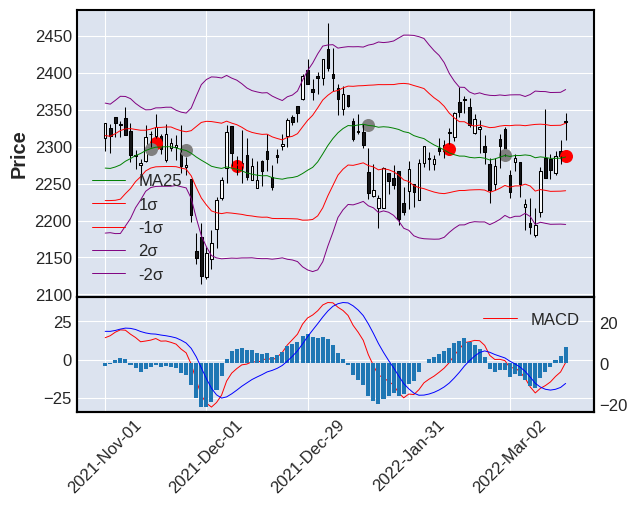

In [4]:
df = get_stock_data(1928)   # 日本製鉄
close = df["Close"]

df['ma5'] = ta.SMA(close ,timeperiod=5)
df['ma25'] = ta.SMA(close ,timeperiod=25)

ma5, ma25 = df['ma5'], df['ma25']
cross  = ma5 > ma25

cross_shift = cross.shift(1)
temp_gc = (cross != cross_shift) & (cross == True)
temp_dc  = (cross != cross_shift) & (cross == False)

# ゴールデンクロス発生日であればMA5の値、それ以外はNaN
gc = [m if g == True else np.nan for g, m in zip(temp_gc, ma5)]

# デッドクロス発生日であればMA25の値、それ以外はNan
dc = [m if d == True else np.nan for d, m in zip(temp_dc, ma25)]

# データフレームのカラムとして保存
df["gc"], df["dc"] = gc, dc


macd, macdsignal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['macd'] = macd
df['macd_signal'] = macdsignal
df['hist'] = hist

df['upper1'], df['middle'], df['lower1'] = ta.BBANDS(close, timeperiod=25, nbdevup=1, nbdevdn=1, matype=0)
df['upper2'], df['middle'], df['lower2'] = ta.BBANDS(close, timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)

# 2021.11.1から2022.3.17までのチャートを作成
rdf = df[dt.datetime(2021,11,1):dt.datetime(2022,3,17)]

apd  = {
          # 25日移動平均線
          "MA25": mpf.make_addplot(rdf['ma25'], color='green', 
                                panel=0, width=0.7), 
          # 1σ
          "1σ": mpf.make_addplot(rdf['upper1'], panel=0, 
                              color='red', width=0.7),
          # -1σ
          "-1σ": mpf.make_addplot(rdf['lower1'], panel=0, 
                              color='red', width=0.7),
          # 2σ
          "2σ": mpf.make_addplot(rdf['upper2'], panel=0, 
                              color='purple', width=0.7),
          # -2σ
          "-2σ": mpf.make_addplot(rdf['lower2'], panel=0, 
                              color='purple', width=0.7),
          # ゴールデンクロス
          "gc": mpf.make_addplot(rdf["gc"],type='scatter',
                              markersize=70,marker='o',color='red'),
          # デッドクロス
          "dc": mpf.make_addplot(rdf["dc"],type='scatter',
                              markersize=70,marker='o',color='gray'),
          # MACD
          "MACD": mpf.make_addplot(rdf['macd'], panel=1, 
                                color='red', width=0.7),
          # シグナル
          "SIGNAL": mpf.make_addplot(rdf['macd_signal'], panel=1, 
                                color='blue', width=0.7),
          # ヒストグラム
          "hist": mpf.make_addplot(rdf['hist'], panel=1, type='bar') 
        }

fig, axes = mpf.plot(rdf, type="candle", figratio=(5,4), 
                      addplot=list(apd.values()), returnfig=True)
axes[0].legend([None]*(len(apd)+2))
handles = axes[0].get_legend().legendHandles
axes[0].legend(handles=handles[2:7], labels=list(apd.keys()))
axes[2].legend(["MACD", "SIGNAL"])
fig.show()